# Tutorial: Data cleansing
In this tutorial, we'll talk about how to use "model objects" in R. 

## Goals:
* Learn how to interact with model objects in R including extracting coefficients
* Learn how to use the `nest()` function
* Learn how to use the `map()` function

---
# Interacting with model objects in R

Whenever you run a regression or any other type of model, the resulting model is saved in an object with properties you can access. This is handy for fitting a model once, and then referencing different aspects of that model's performance and fit. Let's see an example:

In [ ]:
library(tidyverse)

# generate data where y is a function of two variables, x1 and x2
x1 <- seq(-4,4,0.5) #generate data ranging from -4 to 4 in steps of 0.5
x2 <- seq(-4,4,0.5)
#specify a sigmoidal relationship between x1 and y and a linear relationship between x2 and y
dat <- expand.grid(x1=x1, x2=x2)  %>% mutate(y = 1/(1+exp(-x1)) + 0.1*x2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Here is how y depends on x1 and x2:

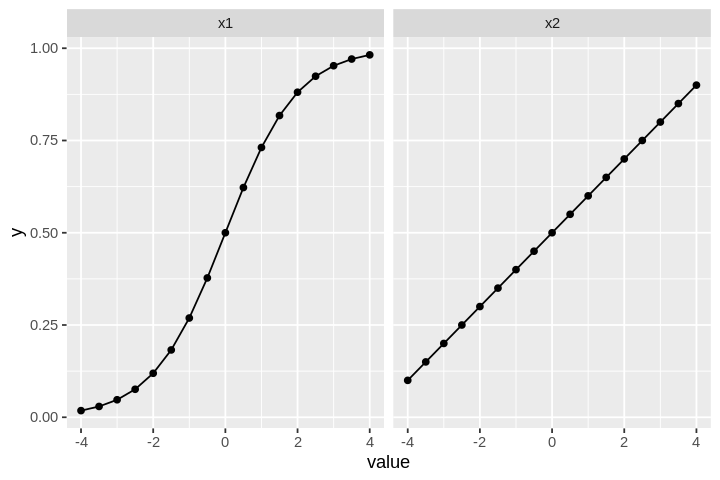

In [ ]:
options(repr.plot.width=6, repr.plot.height=4)
dat  %>%
    gather(var, value, x1, x2)  %>% # make it long format - only x1 or x2 in each row
    ggplot(aes(value, y)) +
    stat_summary(geom='point',fun=mean) +
    stat_summary(geom='line',fun=mean) +
    facet_wrap(~var)

Now, let's add some noise and try to fit a regression model

In [ ]:
dat <- mutate(dat, y_obs = y + rnorm(length(y), mean=0, sd=0.1)) #add normally distributed noise
model_fit <- lm(y_obs ~ x1 + x2, data=dat) #fit a linear model to find the regression coeff.

The resulting model is save in the `model_fit` variable. This is the "model object", and you can do a number of things with it. First, the `str` command, which is a general function for printing the structure of r objects, will tell you what you can find in the model object. As you can see below, it is a list of different variables, which you can access by typing the name of the model, followed by `$variable`.

In [ ]:
str(model_fit) #print the structure of the model object

List of 12
 $ coefficients : Named num [1:3] 0.49 0.145 0.103
  ..- attr(*, "names")= chr [1:3] "(Intercept)" "x1" "x2"
 $ residuals    : Named num [1:289] 0.161087 -0.000838 -0.047814 0.060155 -0.099688 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ effects      : Named num [1:289] -8.3291 6.0409 4.283 0.0562 -0.1037 ...
  ..- attr(*, "names")= chr [1:289] "(Intercept)" "x1" "x2" "" ...
 $ rank         : int 3
 $ fitted.values: Named num [1:289] -0.502 -0.429 -0.357 -0.284 -0.212 ...
  ..- attr(*, "names")= chr [1:289] "1" "2" "3" "4" ...
 $ assign       : int [1:3] 0 1 2
 $ qr           :List of 5
  ..$ qr   : num [1:289, 1:3] -17 0.0588 0.0588 0.0588 0.0588 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:289] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:3] "(Intercept)" "x1" "x2"
  .. ..- attr(*, "assign")= int [1:3] 0 1 2
  ..$ qraux: num [1:3] 1.06 1.08 1.09
  ..$ pivot: int [1:3] 1 2 3
  ..$ tol  : num 1e-07
  ..$ rank : int 3
  ..- attr(*, "class")= c

For example, if we want to extract the estimated regression coefficients, we can type this, which returns a named vector.

In [ ]:
model_fit$coefficients

(Intercept)          x1          x2 
 0.50322978  0.14768216  0.09798459

If we run multiple models, we might want to store these values in a data.frame, rather than a named vector like this:

In [ ]:
coef <- model_fit$coefficients #store the coefficients in a variable
data.frame(name = names(coef), value = coef) #save the name/value of the coefficients in a dataframe

,name,value
,<chr>,<dbl>
(Intercept),(Intercept),0.50322978
x1,x1,0.14768216
x2,x2,0.09798459


You can extract the prediction of the model. They are stored under `$fitted.values`, or you can also get them by typing `fitted(model_fit)`, which returns the same values. Then, we can plot the observed values against the predicted values:

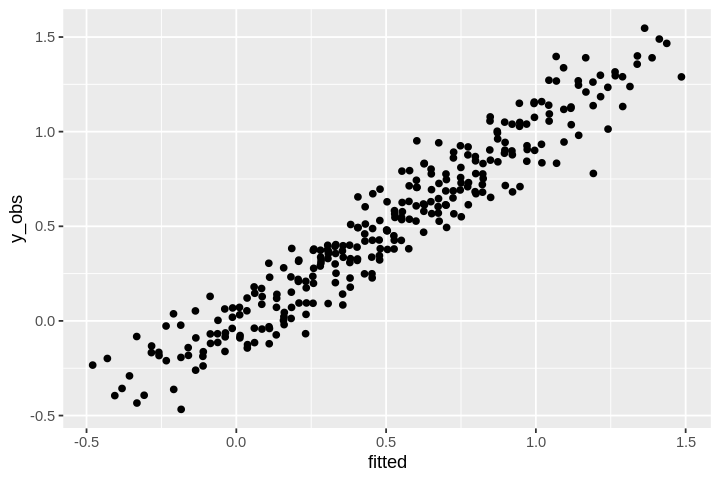

In [ ]:
dat$fitted <- model_fit$fitted.values #extract model estimate of y for each x and store in df as fitted
ggplot(dat, aes(fitted, y_obs)) + #plot against the observed data 
    stat_summary(geom='point',fun=mean)

In [ ]:
head(dat) #dataframe for fitted and obs. values. 

,x1,x2,y,y_obs,fitted
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.0,-4,-0.3820138,-0.2334409,-0.4794372
2,-3.5,-4,-0.3706878,-0.3947202,-0.4055961
3,-3.0,-4,-0.3525741,-0.4338976,-0.3317550
4,-2.5,-4,-0.3241418,-0.1831898,-0.2579140
5,-2.0,-4,-0.2807971,-0.4672971,-0.1840729
6,-1.5,-4,-0.2175745,-0.1628049,-0.1102318


Given your fitted model, you can also easily generate predictions of y given new values of x using the `predict` function: 

In [ ]:
new_data <- data.frame(x1=-5, x2=10) #new x-values to give to the model 
predict(model_fit, newdata = new_data) #predict the y value for a given x 

1 
0.7446649

This is where the fun part comes in. You can use the `nest` and `map` commands from `tidyverse` to fit a model for different subgroups, then extract the results of all models. Let's pretend that x1 is the participant number and we have different subjects, for which we have y and x2 values.

First, nest creates a nested data.frame, in which the data.frame for each group is stored in a different cell

In [ ]:
dat  %>%
    group_by(x1) %>% 
    nest() %>%
    print()

# A tibble: 17 x 2
# Groups:   x1 [17]
      x1 data             
   <dbl> <list>           
 1  -4   <tibble [17 × 3]>
 2  -3.5 <tibble [17 × 3]>
 3  -3   <tibble [17 × 3]>
 4  -2.5 <tibble [17 × 3]>
 5  -2   <tibble [17 × 3]>
 6  -1.5 <tibble [17 × 3]>
 7  -1   <tibble [17 × 3]>
 8  -0.5 <tibble [17 × 3]>
 9   0   <tibble [17 × 3]>
10   0.5 <tibble [17 × 3]>
11   1   <tibble [17 × 3]>
12   1.5 <tibble [17 × 3]>
13   2   <tibble [17 × 3]>
14   2.5 <tibble [17 × 3]>
15   3   <tibble [17 × 3]>
16   3.5 <tibble [17 × 3]>
17   4   <tibble [17 × 3]>


Remember, we want to fit models to each subgroup. The `map` function applies a given function to a set of data in an iterative way -- so this would be a convenient approach. Some of the benefits of using `map` are that you do not have to write a series of for-loops (it's efficient/vectorized) and it makes your code easier to read (and thus error check). Now you can use `map` to fit a model to each subgroup like this:

In [ ]:
dat  %>% 
    group_by(x1)  %>% 
    nest()  %>% 
    mutate(model_fit = map(data, function(data) lm(y_obs ~ x2, data=data)))  %>% 
    print()

# A tibble: 17 x 3
# Groups:   x1 [17]
      x1 data              model_fit
   <dbl> <list>            <list>   
 1  -4   <tibble [17 × 3]> <lm>     
 2  -3.5 <tibble [17 × 3]> <lm>     
 3  -3   <tibble [17 × 3]> <lm>     
 4  -2.5 <tibble [17 × 3]> <lm>     
 5  -2   <tibble [17 × 3]> <lm>     
 6  -1.5 <tibble [17 × 3]> <lm>     
 7  -1   <tibble [17 × 3]> <lm>     
 8  -0.5 <tibble [17 × 3]> <lm>     
 9   0   <tibble [17 × 3]> <lm>     
10   0.5 <tibble [17 × 3]> <lm>     
11   1   <tibble [17 × 3]> <lm>     
12   1.5 <tibble [17 × 3]> <lm>     
13   2   <tibble [17 × 3]> <lm>     
14   2.5 <tibble [17 × 3]> <lm>     
15   3   <tibble [17 × 3]> <lm>     
16   3.5 <tibble [17 × 3]> <lm>     
17   4   <tibble [17 × 3]> <lm>     


The resulting models are stored in each cell of the model_fit column. You can then extract the coefficients for each model:

In [ ]:
dat  %>% 
    group_by(x1)  %>% 
    nest()  %>% 
    mutate(model_fit = map(data, function(data) lm(y_obs ~ x2, data=data)),
           coef = map(model_fit, function(fit) data.frame(name=names(fit$coefficients), beta=fit$coefficients)))  %>% 
    print()

# A tibble: 17 x 4
# Groups:   x1 [17]
      x1 data              model_fit coef            
   <dbl> <list>            <list>    <list>          
 1  -4   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 2  -3.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 3  -3   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 4  -2.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 5  -2   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 6  -1.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 7  -1   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 8  -0.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
 9   0   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
10   0.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
11   1   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
12   1.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
13   2   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
14   2.5 <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
15   3   <tibble [17 × 3]> <lm>      <df[,2] [2 × 2]>
16   3.5 <tibble [17 × 3]> <lm>      <df[,2

They are again stored in a column called coef. If you want to then finally just get a data.frame with coefficients, you can unnest the results:

In [ ]:
dat  %>% 
    group_by(x1)  %>% 
    nest()  %>% 
    mutate(model_fit = map(data, function(data) lm(y_obs ~ x2, data=data)),
           coef = map(model_fit, function(fit) data.frame(name=names(fit$coefficients), beta=fit$coefficients))) %>%
    unnest(coef) %>%
    print()

# A tibble: 34 x 5
# Groups:   x1 [17]
      x1 data              model_fit name          beta
   <dbl> <list>            <list>    <chr>        <dbl>
 1  -4   <tibble [17 × 3]> <lm>      (Intercept) 0.0333
 2  -4   <tibble [17 × 3]> <lm>      x2          0.0868
 3  -3.5 <tibble [17 × 3]> <lm>      (Intercept) 0.0219
 4  -3.5 <tibble [17 × 3]> <lm>      x2          0.0974
 5  -3   <tibble [17 × 3]> <lm>      (Intercept) 0.0599
 6  -3   <tibble [17 × 3]> <lm>      x2          0.0887
 7  -2.5 <tibble [17 × 3]> <lm>      (Intercept) 0.0332
 8  -2.5 <tibble [17 × 3]> <lm>      x2          0.103 
 9  -2   <tibble [17 × 3]> <lm>      (Intercept) 0.121 
10  -2   <tibble [17 × 3]> <lm>      x2          0.109 
# … with 24 more rows


You can find additional information on this approach here: http://omaymas.github.io/Climate_Change_ExpAnalysis/

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, and Amy Sentis.*